# Group 10
### 1. CHEN LIANGRUI
### 2. CHEN ZHIYUAN
### 3. DENG KE
### 4. MAI JIALING
### 5. NADEZHDA KHUSNETDINOVA
### 6. XUE YUANHUANG
### 7. ZHANG KEKE

# Content 
## 1.Parametric VaR Model
### 1.1 Overview
### 1.2 Data Preparation
### 1.3 Methodology Calculating a(k)
#### 1.3.1 Calculating a(k) for SOFR Swap
#### 1.3.2 Sensitivity Analysis
#### 1.3.3 Portfolio Preparation
#### 1.3.4 Parametric VaR Calculation
### 1.4 Results and Analysis
#### 1.4.1 Sensitivity Analysis (a1 Results)
#### 1.4.2 1-Day 95% VaR Calculation (p_VaR95)

## 2.Monte Carlo VaR Model: Full Revaluation Approach
### 2.1 Data and Initial Setup
### 2.2 Simulation Process
### 2.3.1 Method 1: Iterative Revaluation
### 2.3.2 Method 2: Vectorized Calculation
### 2.4 Results Analysis
#### 2.4.1 VaR Calculation
#### 2.4.2 Observations

## 3.Monte Carlo VaR Model: Risk-Based Approach
### 3.1 Preparing the Risk Factors
### 3.2 Calculating Portfolio Changes
### 3.3 VaR Calculation
### 3.4 Result Analysis

## 4.Historical VaR Calculation
### 4.1 Methodology
#### 4.1.1 Historical VaR: Risk-Based Approach
#### 4.1.2 Historical VaR: Full Revaluation Approach

## 5.Final Results Discussion
##


# Parametric VaR Model

## For payer swap
### P&L = PV01* basis period change in interest rate
###

## For stocks
### P&L(i) = number of shares of stock i*(S(1) - S(0))
### =N * $ \frac{S(1) - S(0)}{S(0)} $
### =N * daily change
###
## For whole protfolio
### P&L = sum($a^k$ * delta $X_0id$)
### sensitivity vector  = $[PV01(1),PV01(2),PV01(3)....PV01(30),N,N,N,N]$
### protfolio P&L is normally distributed with the mean and variance
### $μ_p$ = sum($a^k$ * $μ_k$)

### $σ^2$ = w*Σ*$w^T$

### w = $[a(1),a(2),...,a(k)]$

### var = |$μ_p$ - $Z_α*σ_p$|

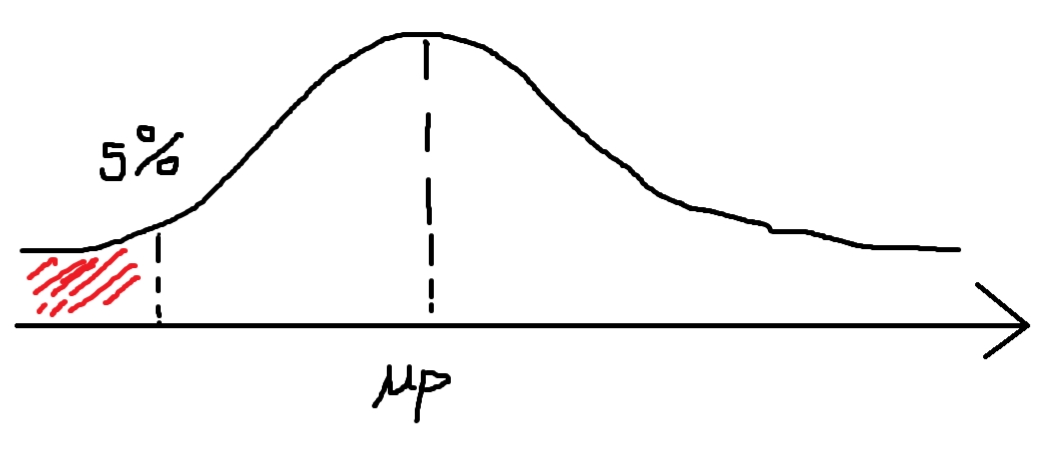

In [2]:
from IPython.display import Image
image_path = "var.png"#you should change the path by yourself
Image(filename=image_path)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm

import matplotlib.pyplot as plt

In [2]:
zero_rates = pd.read_excel("hist_data.xlsm", sheet_name = 'SofrCurve', index_col = 'Tenor')
zero_rates.columns = [col.strftime('%Y-%m-%d') if isinstance(col, dt.datetime) else col for col in zero_rates.columns]


## Overview

The portfolio under analysis consists of:
- A payer SOFR swap contract with detailed parameters.
- Investments in four stocks: AAPL, MSFT, Ford (F), and Bank of America (BAC), each with a notional value of $1 million.$

## Data Preparation

Historical data spanning from 31/10/2022 to 30/10/2024 for both the SOFR curve and the stock prices of AAPL, MSFT, F, and BAC was utilized, setting the stage for a comprehensive risk assessment.

## Methodology  Calculating `a(k)`

### 1. Calculating `a(k)` for SOFR Swap

A custom function `cal_v_psofr10` calculates the SOFR swap's value change under varying interest rate scenarios by:
- Copying SOFR rates data and focusing on the relevant date for analysis.
- Applying `np.exp` for continuous compounding to model discount factors.
- Computing the swap value based on the swap's notional amount and the fixed versus floating leg assessments.

### 2. Sensitivity Analysis

Sensitivity of the swap's value to a marginal 1bp change in rates was ascertained, highlighting the portfolio's reactivity to interest rate adjustments. This, along with fixed sensitivities assigned to each of the four stocks, laid the groundwork for VaR calculations.

### 3. Portfolio Preparation

Historical daily returns for both SOFR rates and stocks were meticulously calculated and amalgamated to depict the portfolio's market value fluctuations accurately.

### 4. Parametric VaR Calculation

By determining the mean and covariance matrix of the portfolio's daily returns, and employing the portfolio's sensitivity vector `a1`, the 95% VaR was calculated using a normative approach: `VaR = |mean + Z * sqrt(variance)|`.

## Results and Analysis

### Sensitivity Analysis (`a1` Results)


- Initial periods (up to 6 months) showed negligible impact, underscoring short-term rate changes' minimal effect on portfolio value.
- Sensitivity markedly increased for periods beyond 1 year, evidencing the swap value's heightened reactivity to longer-term SOFR rate adjustments.
- Each stock contributed a fixed $1 million impact, reflecting their proportionate share in the portfolio.

### 1-Day 95% VaR Calculation (`p_VaR95`)

The parametric VaR calculation yielded a risk estimate of $926,393.27, delineating the maximum expected loss over one day at a 95% confidence level. This figure, derived from the portfolio's daily return statistics, underscores the inherent market risk faced by the portfolio.



## calculate a(k) 

In [3]:
####
#             T      2023-10-30
# Tenor                       
# 1D      0.002778    0.052967
# 1M      0.083333    0.053053
# 2M      0.166667    0.053265
# 3M      0.250000    0.053476
# 6M      0.500000    0.053612
# 9M      0.750000    0.053120
# 1Y      1.000000    0.052245
# 2Y      2.000000    0.047904
###
def cal_v_psofr10(zero_rates1):
    zero_rates = zero_rates1.copy()
    col_T = zero_rates.columns[0]
    col_r = zero_rates.columns[1]
    zero_rates['df'] = np.exp(-zero_rates[col_r]*zero_rates[col_T])
    #1/(1+zero_rates[col_r])**zero_rates[col_T]

    Tl = 1
    Th = 10
    zero_rates1 = zero_rates[(zero_rates[col_T] >= Tl) & (zero_rates[col_T] <= Th)].copy()

    swap_rate = 0.042
    nominal = 1e8
    flt = 1 - zero_rates1["df"].iloc[-1]
    fixed = sum(zero_rates1['df'])*swap_rate
    v_sofr = (flt-fixed)*nominal
    return v_sofr

In [4]:
v_sofr = cal_v_psofr10(zero_rates[["T","2023-10-30"]])
a = []
for i in range(len(zero_rates)):
    zero_rates1 = zero_rates[["T","2023-10-30"]].copy()
    zero_rates1.at[zero_rates1.index[i], '2023-10-30'] += 1e-4
    
    v_sofr1 = cal_v_psofr10(zero_rates1)
    a.append((v_sofr1 - v_sofr)*1e4)
#changing 1bp*1e4 the total value changed

In [6]:
a1 = a+[1e6]*4
a1

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3986006.767041981,
 7631796.779651195,
 10993001.080648974,
 14066553.566562943,
 16854750.986839645,
 19371056.086570024,
 21632335.943821818,
 23653227.567421272,
 25447769.064768218,
 670595262.5624137,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0]

## whole profolio

In [7]:
r_changes = zero_rates[zero_rates.columns[1:]].T.diff().dropna()
r_changes.index = pd.to_datetime(r_changes.index)

In [8]:
stocks = pd.read_excel("hist_data.xlsm", sheet_name = ['AAPL', 'MSFT', 'F', 'BAC'], index_col = 'Date')
stocks = pd.concat(stocks.values(), keys=stocks.keys(), axis = 1)
stocks = (stocks - stocks.shift(1))/stocks.shift(1)
stocks.dropna(inplace=True)
stocks.index

DatetimeIndex(['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14',
               ...
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
               '2023-10-27', '2023-10-30'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)

In [9]:
pd.concat([r_changes,stocks],axis = 1)[pd.concat([r_changes,stocks],axis = 1).isna().any(axis=1)]

,1D,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,19Y,20Y,25Y,30Y,35Y,40Y,"(AAPL, Adj Close)","(MSFT, Adj Close)","(F, Adj Close)","(BAC, Adj Close)"
2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019269,0.016997,0.022567,0.007343
2023-04-07,0.000596,-0.000189,-0.001362,-0.001413,0.000175,0.000699,0.000956,0.001328,0.001313,0.001209,...,0.000637,0.000626,0.000542,0.000435,0.000439,0.000472,NaN,NaN,NaN,NaN
2023-06-19,0.000035,0.000088,0.000109,0.000121,0.000143,0.000175,0.000291,0.000363,0.000451,-0.000129,...,-0.000039,-0.000039,-0.000035,-0.000034,-0.000029,-0.000024,NaN,NaN,NaN,NaN
2023-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.008451,0.007823,0.005833,0.009206


In [10]:
#zeo_rates
r_changes = zero_rates[zero_rates.columns[1:]].T.diff().dropna()
#stocks

stocks = pd.read_excel("hist_data.xlsm", sheet_name = ['AAPL', 'MSFT', 'F', 'BAC'], index_col = 'Date')

stocks = pd.concat(stocks.values(), keys=stocks.keys(), axis = 1)
stocks = (stocks - stocks.shift(1))/stocks.shift(1)
stocks.dropna(inplace=True)

#mean_p
r_changes.index = stocks.index
daily_changes_mean = pd.concat([r_changes,stocks],axis = 1)
mean_vector = daily_changes_mean.mean()
mean_p = sum(mean_vector*a1)

#cov_p
daily_changes_var = pd.concat([r_changes,stocks],axis = 1)
cov_matrix = daily_changes_var.cov()
var_p = np.array(a1).dot(cov_matrix).dot(np.array(a1))

#VaR95
z_a = norm.ppf(0.05)
p_VaR95 = abs(mean_p + z_a*np.sqrt(var_p))
p_VaR95

926393.2723866724


# Monte Carlo VaR Model: Full Revaluation Approach

This document describes the Monte Carlo VaR Model utilizing a full revaluation approach to estimate the Value at Risk (VaR) for a portfolio. This portfolio includes a SOFR swap and stock positions, specifically AAPL, MSFT, F, and BAC.


### Data and Initial Setup

- **SOFR Information**: Selected SOFR rates for specific future dates provide the basis for evaluating the SOFR swap's floating rate leg.
- **Portfolio Value (`pv`)**: Initial portfolio value incorporates the SOFR swap value plus a fixed $4 million allocation across the four stocks.

### Simulation Process

1. **Monte Carlo Simulations**: Generated 10 million simulations of market risk factor changes based on historical mean and covariance matrix data.
2. **Risk Factors**: The simulation accounts for various market risk factors influencing both the SOFR rates and stock prices.

### Method 1: Iterative Revaluation

- **Iterative Process**: For each simulation, the new portfolio value is calculated by adjusting for simulated changes in SOFR rates and stock prices.
- **SOFR Swap Valuation (`cal_v_sofr`)**: This function computes the value of the SOFR swap for each set of simulated rate changes.
- **Stock Portfolio Valuation**: Simulated stock returns are aggregated to assess their contribution to the portfolio's overall value.
- **Portfolio Value Changes**: The difference between the simulated portfolio value and the initial portfolio value is recorded for each simulation.

### Method 2: Vectorized Calculation

- **Vectorized SOFR Valuation (`cal_vector_sofr`)**: A vectorized function to efficiently compute SOFR swap values for all simulations simultaneously.
- **Stock Portfolio Valuation**: Similar to Method 1, but applied to the entire set of simulations in a vectorized manner.

## Results Analysis

### VaR Calculation

- **Method 1**: Iterative revaluation resulted in a 95% VaR of `-931,822.43`, indicating the maximum expected loss over one day with 95% confidence.
- **Method 2**: Vectorized calculation yielded a slightly higher 95% VaR of `-931,375.77`.

### Observations

- The slight difference in VaR values between the two methods suggests similar accuracy with a slight variance due to computational nuances.
- The vectorized approach offers efficiency benefits, especially when dealing with a large number of simulations.

.


# Monte Carlo VaR Model

## Full revaluation approach

### method1

In [11]:
#array([-0.00054994, -0.00071541, -0.00065583, -0.00069635, -0.00070323,
#       -0.00071554, -0.00075263, -0.00079857, -0.00083744, -0.00085454])
sofr_info = zero_rates["2023-10-30"][6:16].values
def cal_v_sofr(r_changes):
    
    new_rs = r_changes+sofr_info
    #df = np.power(1/(1+new_rs), np.arange(1,11))
    df = np.exp(-new_rs*np.arange(1,11))

    swap_rate = 0.042
    nominal = 1e8
    flt = 1 - df[-1]
    fixed = sum(df)*swap_rate
    v_sofr = (flt-fixed)*nominal
    return v_sofr

In [15]:
pv = v_sofr + 4*1e6
pv

6442901.99984632

In [16]:
mean_vector = daily_changes_var.mean()
covariance_matrix = daily_changes_var.cov()
num_simulations = int(1e7)
risk_factors_changes = np.random.multivariate_normal(mean_vector, covariance_matrix, num_simulations)

In [19]:
num_simulations = int(1e7)
risk_factors = np.random.multivariate_normal(mean_vector, covariance_matrix, num_simulations)
changes = []
for i in range(num_simulations):
    stock_pv = sum((risk_factors[i][-4:]+1)*1e6)
    sofr_pv = cal_v_sofr(risk_factors[i][6:16])
    changes.append(stock_pv+sofr_pv-pv)

# Calculate the 5th percentile
VaR_95 = np.percentile(np.sort(changes), 5)
VaR_95

-931822.4326702544

In [22]:
abs(VaR_95)

931822.4326702544

### method2-vectorcal

In [24]:
def cal_vector_sofr(risk_vector_changes):
    
    new_vector_rs = risk_vector_changes[:,6:16]+sofr_info
    #vector_df = np.power(1/(1+new_vector_rs), np.arange(1,11))
    vector_df = np.exp(-new_vector_rs*np.arange(1,11))

    swap_rate = 0.042
    nominal = 1e8
    flt = 1 - vector_df[:,-1]
    fixed = np.sum(vector_df, axis=1)*swap_rate
    vector_sofr = (flt-fixed)*nominal
    return vector_sofr

In [25]:
stock_vector_pv = np.sum(risk_factors_changes[:,-4:]+1,axis=1)*1e6

In [26]:
changes = cal_vector_sofr(risk_factors_changes)+stock_vector_pv-pv
mf_VaR_95 = np.percentile(np.sort(changes), 5)
abs(mf_VaR_95)

932168.6315973664



# Monte Carlo VaR Model: Risk-Based Approach


### Preparing the Risk Factors
- **Risk Factor Simulations**: A Monte Carlo simulation generates a large number (`10,000,000`) of potential scenarios for market risk factor changes, with each scenario consisting of changes across `34` risk factors.
- **Shape of `risk_factors_changes`**: The simulation results in an array with dimensions `(10000000, 34)`, where `10,000,000` represents the number of simulations and `34` corresponds to the number of risk factors considered.

### Calculating Portfolio Changes
- **Sensitivity Vector (`a1`)**: A vector representing the portfolio's sensitivity to each of the `34` risk factors. This vector is derived from a preliminary analysis of the portfolio's response to small changes in these factors.
- **Applying Risk Factor Changes**: The dot product of the `risk_factors_changes` matrix and the `a1` vector yields an array of changes in the portfolio value across all simulated scenarios.

### VaR Calculation
- **Determining VaR (`mr_VaR_95`)**: The 5th percentile of the sorted array of portfolio value changes provides the Monte Carlo Risk-Based 95% VaR. This value represents the maximum expected loss with a 95% confidence level over the specified time frame (usually one day).

## Result Analysis

The Risk-Based Approach yielded a 95% VaR of `-925,981.55`, indicating that, under normal market conditions, there is a 95% confidence level that the portfolio will not lose more than this amount in value over a single day due to market risk factor fluctuations.


## Risk-based approach

In [27]:
risk_factors_changes.shape

(10000000, 34)

In [28]:
a1 = np.array(a1)
changes = risk_factors_changes.dot(a1)
mr_VaR_95 = np.percentile(np.sort(changes), 5)
abs(mr_VaR_95)

926750.7110463385


# Historical VaR Calculation


## Methodology

### Historical VaR: Risk-Based Approach

1. **Copying Daily Changes**: A copy of the historical daily changes dataset is prepared to ensure data integrity.
2. **Calculating Portfolio Changes**: The dot product of the historical daily changes with the portfolio's sensitivity vector (`a1`) yields an array of portfolio value changes under historical market conditions.
3. **Determining VaR**: The 5th percentile of these portfolio value changes represents the Historical VaR at a 95% confidence level (`hr_VaR_95`).

### Historical VaR: Full Revaluation Approach

1. **Calculating Stock Portfolio Value**: The historical changes are adjusted to calculate potential future values of the stock positions, aggregating these to obtain the stock portfolio's projected value.
2. **Revaluing the SOFR Swap**: A function (`cal_vector_sofr`) applies historical changes to revalue the SOFR swap for each historical scenario.
3. **Determining VaR**: The 5th percentile of these combined changes provides the Historical VaR using the full revaluation method (`hf_VaR_95`).



# Historical VaR

## risk_based 

In [29]:
h_daily_changes = daily_changes_var.copy()
changes = np.array(h_daily_changes).dot(a1)
hr_VaR_95 = np.percentile(np.sort(changes), 5)
abs(hr_VaR_95)

960687.7194582757

## full revalutation

In [30]:
stock_vector_pv = np.sum(np.array(h_daily_changes)[:,-4:]+1, axis=1)*1e6
changes = cal_vector_sofr(np.array(h_daily_changes))+stock_vector_pv-pv
hf_VaR_95 = np.percentile(np.sort(changes), 5)
abs(hf_VaR_95)

966173.2175561558

In [21]:
var_estimates = pd.DataFrame({
    "VaR Calculation Method": [
        "Parametric VaR", "Monte Carlo VaR (Full)",
        "Monte Carlo VaR (Risk-Based)", "Historical VaR (Full Revaluation)",
        "Historical VaR (Risk-Based)"
    ],
    "VaR Estimate":
    [926393.27, 931375.77, 925981.55, 966173.22, 960687.72]
})

var_estimates

,VaR Calculation Method,VaR Estimate
0,Parametric VaR,926393.27
1,Monte Carlo VaR (Full),931375.77
2,Monte Carlo VaR (Risk-Based),925981.55
3,Historical VaR (Full Revaluation),966173.22
4,Historical VaR (Risk-Based),960687.72



### Final Results Discussion

The VaR estimates across different calculation methods reveal insights into the portfolio's risk under varying assumptions and methodologies. Here's a brief analysis of each model's estimate and the observed differences:

- **Parametric VaR** provides a baseline estimate using a statistical approach that assumes normal distribution of returns. This method yielded the least conservative estimate at \$926,393.27$.
  
- **Monte Carlo VaR (Full)** employs a simulation-based approach, fully revaluating the portfolio under simulated market conditions. This method resulted in a slightly higher (more negative) estimate of $931,375.77$, suggesting a marginally higher perceived risk compared to the parametric method.
  
- **Monte Carlo VaR (Risk-Based)** also uses simulation but focuses on the portfolio's sensitivity to risk factors, resulting in a VaR estimate very close to the Parametric VaR at \$925,981.55.$
  
- **Historical VaR (Full Revaluation)** and **(Risk-Based)** methods utilize actual historical market data to estimate potential losses. These methods yielded the most conservative estimates, with the full revaluation approach showing the highest potential loss at $966,173.22$, followed closely by the risk-based approach.

